<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization_2_Factor_Single_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization by considering an investor who instead of simply optimizing the mean variance criterion, uses a linear boundary to decide what assets are to be included in the long-only portfolio. The investor will select the bundary to be of maximum margin while minimizing the portfolio variance. 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [55]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
drive.mount('/content/gdrive')
from math import sqrt
import math
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
%matplotlib inline


## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

# import matplotlib
# import matplotlib.font_manager as fm
#
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
# matplotlib.rc('font', family='TH Sarabun New')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
try:
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey 2d15bcec-464e-11ec-8a74-0242ac120003
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


In [57]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [116]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Momentum"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
#Y_['momentum'] = mean
Y_ = Y_[['LEV1', 'GRW1']]
#Y_['momentum'] = mean
AssetLim = math.floor(N*0.8)
ret_constr = -1
soft_margin = 5000
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [117]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<Figure size 432x288 with 0 Axes>

### Simple Min Variance Portfolio 

In [118]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 2 rows, 300 columns and 300 nonzeros
Model fingerprint: 0x014b9800
Model has 11325 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 150 columns
Presolve time: 0.03s
Presolved: 2 rows, 150 columns, 300 nonzeros
Presolved model has 11325 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 149
 AA' NZ     : 1.132e+04
 Factor NZ  : 1.148e+04
 Factor Ops : 1.159e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

0.14600014686584473

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca

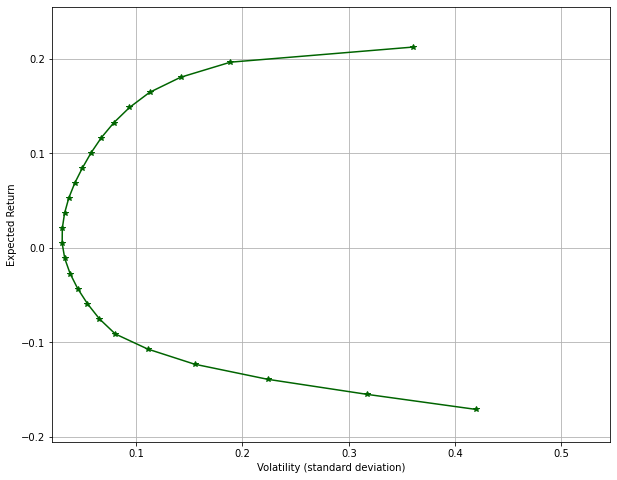

In [119]:
MVO.model.setParam('OutputFlag', 0)
MVO_frontier, ws, xis = MVO.get_frontier(); #ws and xi are not important here

### Mean Variance and SVM Joint Formulation

In [120]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
                 svm_choice = (True, False), print_var_frntr = False , indicator = False)
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 603 rows, 453 columns and 2250 nonzeros
Model fingerprint: 0x159ad89e
Model has 11327 quadratic objective terms
Variable types: 303 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+05]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+02]
Presolve removed 121 rows and 210 columns
Presolve time: 0.03s
Presolved: 482 rows, 243 columns, 1680 nonzeros
Presolved model has 11327 quadratic objective terms
Variable types: 153 continuous, 90 integer (90 binary)

Root relaxation: objective 9.175389e-04, 231 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

4.035498380661011

In [121]:
SVM_MVO.get_frontier()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 603 rows, 453 columns and 2250 nonzeros
Model fingerprint: 0x5aa15bbd
Model has 11327 quadratic objective terms
Variable types: 303 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+05]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 120 rows and 210 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.06 seconds
Thread count was 1 (of 2 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
Resolving Model to initial state (return target) then exiting

(None, None, None)

### There must be a model that is guaranteed to be feasible. Slack variables for the big M constraints will be introduced and penalized. These slack variables $\xi$ represent the degree of non-separability present among the assets

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad \xi \geq 0& \\
\end{align} 
$$

This model is always feasible. A common setting for g is $C \xi/N$ where $C$ is a hyperparameter. 

In [122]:
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
                      svm_choice = (True, True), print_var_frntr = True, indicator = False)
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 603 rows, 603 columns and 2550 nonzeros
Model fingerprint: 0x259e15f9
Model has 11327 quadratic objective terms
Variable types: 453 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+05]
  Objective range  [3e+01, 3e+01]
  QObjective range [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+02]
Found heuristic solution: objective 1.000000e+13
Presolve removed 1 rows and 150 columns
Presolve time: 0.01s
Presolved: 602 rows, 453 columns, 2340 nonzeros
Presolved model has 11327 quadratic objective terms
Variable types: 303 continuous, 150 integer (150 binary)

Root relaxation: objective 9.171821e-04, 376 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bo

4.279548406600952

In [123]:
SVM_MVO_Slck.soft_penalty.getValue()

array([0.])

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 603 rows, 603 columns and 2550 nonzeros
Model fingerprint: 0x63e6062e
Model has 11327 quadratic objective terms
Variable types: 453 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+05]
  Objective range  [3e+01, 3e+01]
  QObjective range [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 0 rows and 150 columns
Presolve time: 0.01s
Presolved: 603 rows, 453 columns, 2490 nonzeros
Presolved model has 11327 quadratic objective terms
Variable types: 303 continuous, 150 integer (150 binary)

Root relaxation: objective 8.431175e-01, 454 iterations, 0.01 seconds

    Nodes    |    Current No

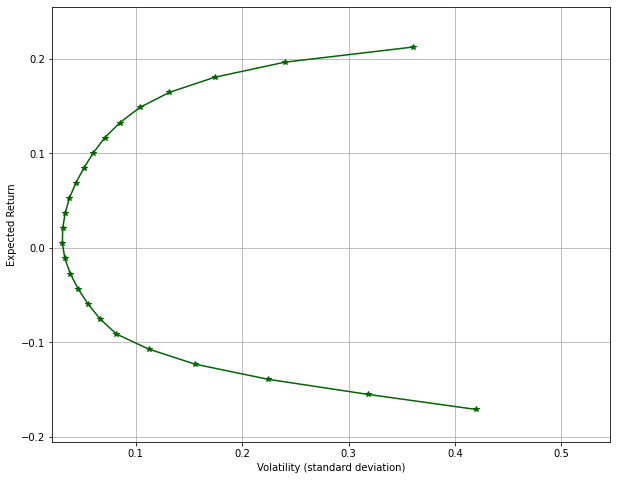

In [124]:
#SVM_MVO_Slck.model.setParam('OutputFlag', 0)
SVM_Slck_EF, ws, xis = SVM_MVO_Slck.get_frontier()

In [125]:
pth

'gdrive/My Drive/Colab Notebooks/'

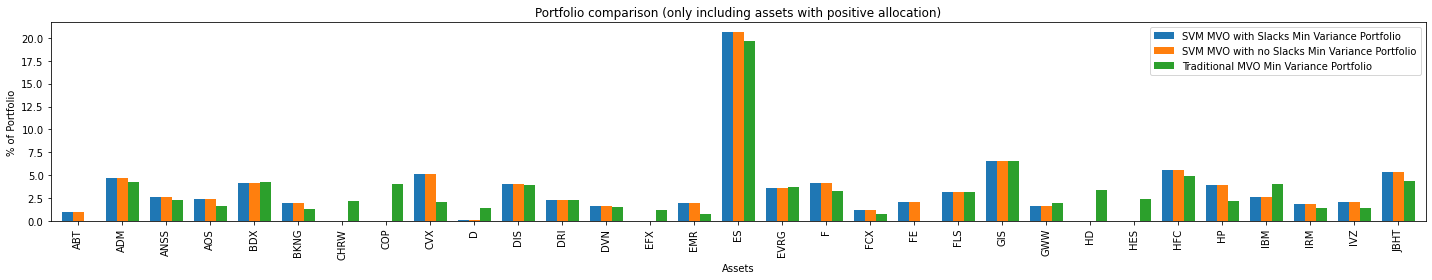

In [126]:
#portfolio comparison
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
(100*out[out.columns[(out > 0.01).any(axis = 0)]]).transpose()[:-2].plot.bar(title = 'Portfolio comparison (only including assets with positive allocation)',\
                                                                           xlabel = 'Assets', \
                                                                           ylabel = '% of Portfolio',\
                                                                           figsize = (20,4), width = 0.75);
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p1.png", dpi = dpi_setting)

For the portfolios up to the return point of 0.3, the solver finds linearly separable portfolios. After that point the solver defaults to including all the assets in the universe at the expense of increasing the cost of violating the linearly separable condition. 

The bias term acts as a radius that determines how far separating hyperplanes can be from the origin. If the bias was free to be any value then, it would be set to ensure z = 1 for all assets, which would imply w = 0, no constraint violations xi = 0 (since all assets are covered), and would therefore reduce the problem to the mean variance problem. 

The bias could be set to cover a percentile of assets feature vectors Y ? 

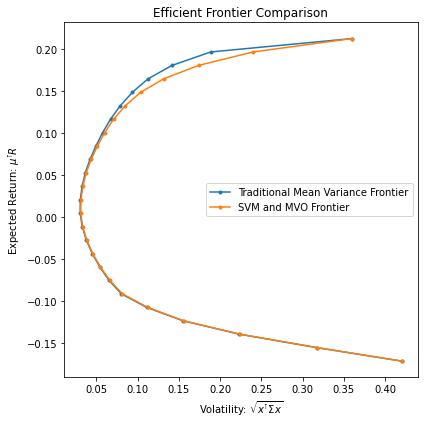

In [127]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(MVO_frontier[0], MVO_frontier[1], ".-", label = "Traditional Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], ".-", label = "SVM and MVO Frontier");
plt.legend();
plt.ylabel('Expected Return: $\mu^{\intercal}R$')
plt.xlabel('Volatility: $\sqrt{x^{\intercal} \Sigma x}$')
plt.legend()
plt.title("Efficient Frontier Comparison");
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p2.png", dpi = dpi_setting)

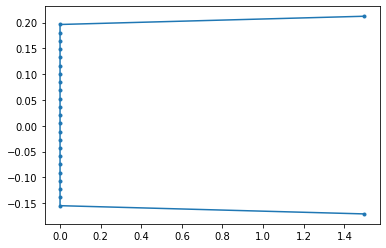

In [128]:
plt.plot(xis.sum(axis= 1), SVM_Slck_EF[1], ".-", label = "Slacks for each target");

In [129]:
from sympy.solvers import solve
from sympy import Symbol

xu, yu = tuple(np.ceil(Y_.max()))
xl, yl = tuple(np.floor(Y_.min()))
epsi = 10**(-1)

def getline(ws):
  x = Symbol('x')
  y = Symbol('y')
  epsi = 10**(-9)

  if abs(ws[0]) >= epsi and abs(ws[1]) >=epsi:
    try:
      xxu = float(solve(ws[0]*x  + ws[1]*yu + ws[2]  , x)[0].evalf())
      xxl = float(solve(ws[0]*x  + ws[1]*yl + ws[2]  , x)[0].evalf())
      yyl = float(solve(ws[0]*xl  + ws[1]*y + ws[2]  , y)[0].evalf())
      yyu = float(solve(ws[0]*xu  + ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      xxu = (-1)*(ws[1]*yu + ws[2])/ws[0]
      xxl = (-1)*(ws[1]*yl + ws[2])/ws[0]
      yyl = (-1)*(ws[0]*xl + ws[2])/ws[1]
      yyu = (-1)*(ws[0]*xu + ws[2])/ws[1]

    candidates = [(xxu, yu), (xxl, yl), (xl, yyl), (xu, yyu) ]
    tuples = []
    for tup in candidates:
      if tup[0] <= xu and tup[0] >= xl and tup[1] <= yu and tup[1] >= yl:
        tuples.append(tup)

  elif abs(ws[0]) >= epsi and abs(ws[1]) < epsi: #y coeff is small
    try:
      xx = float(solve(ws[0]*x + ws[2]  , x)[0].evalf())
    except:
      xx = (-1)*ws[2]/ws[0]
    

    if xx <= xu and xx >= xl:
      tuples = [(xx, yl), (xx, yu)]
    elif xx > xu:
      tuples = [(xu, yl), (xu, yu)]
    elif xx < xl:
      tuples = [(xl, yl), (xl, yu)]

  elif abs(ws[0]) < epsi and abs(ws[1]) >= epsi: #x coeff is small
    try:
      yy = float(solve(ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      yy =  (-1)*ws[2]/ws[1]
    
    if yy <= yu and yy >= yl:
      tuples = [(xu, yy), (xl, yy)]
    elif yy > yu:
      tuples = [(xu, yu), (xl, yu)]
    elif yy < yl:
      tuples = [(xl, yl), (xl, yl)]

  else: 
    print("No Valid Separating Hyperplanes")
    return None 
  return tuples

In [130]:
supports  = pd.DataFrame(ws)
supports['ret'] = SVM_Slck_EF[1,:]
bigM = 10**(6)
supports_uniq = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).first()
supports_uniq['last_ret'] = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).last()['ret']
supports_uniq['desc'] = "Return Target : " +  np.round(supports_uniq['ret'], decimals = 2).astype(str) \
                      +  " to " + np.round(supports_uniq['last_ret'], decimals = 2).astype(str) 

for idx in supports_uniq.index:
  if supports_uniq.loc[idx,'last_ret'] == supports_uniq.loc[idx,'ret']:
    supports_uniq.loc[idx, 'desc'] = "Return Target : " + \
                                      np.round(supports_uniq.loc[idx,'ret'], decimals = 2).astype(str)
supports_uniq

,,,0,1,2,ret,last_ret,desc
0,1,2,,,,,,
0.001006,0.000000,0.000000,0.001006,0.000000,0.000000,0.212266,0.212266,Return Target : 0.21
0.001029,0.001125,0.000000,0.001028,0.001124,0.000000,-0.170884,-0.170884,Return Target : -0.17
0.145868,0.333286,0.040461,0.145868,0.333286,0.040461,-0.154920,0.196301,Return Target : -0.15 to 0.2


In [131]:
supports

,0,1,2,ret
0,0.001028,0.001124,0.000000,-0.170884
1,0.145868,0.333286,0.040461,-0.154920
2,0.145868,0.333286,0.040461,-0.138955
3,0.145868,0.333286,0.040461,-0.122990
4,0.145868,0.333286,0.040461,-0.107026
5,0.145868,0.333286,0.040461,-0.091061
6,0.145868,0.333286,0.040461,-0.075097
7,0.145868,0.333286,0.040461,-0.059132
8,0.145868,0.333286,0.040461,-0.043168
9,0.145868,0.333286,0.040461,-0.027203


0
1
2


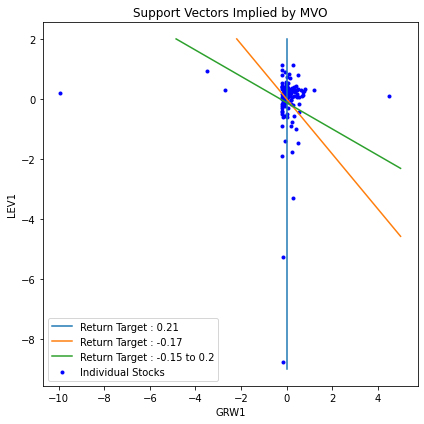

In [132]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=Y_.iloc[:,0], y=Y_.iloc[:,1],
           color='Blue', label='Individual Stocks', marker = '.')
#for stock in Y_.index:
  #ax.annotate(stock, (Y_.loc[stock][0], Y_.loc[stock[1]))
for i in range(supports_uniq[[0,1,2]].values.shape[0]):
  print(i)
  line = getline(supports_uniq[[0,1,2]].values[i,:])
  if line is not None:
    ax.plot(*zip(*line), label = supports_uniq.iloc[i]['desc'])
plt.legend();
plt.ylabel(Y_.columns[0])
plt.xlabel(Y_.columns[1])
plt.title('Support Vectors Implied by MVO')
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p3.png",dpi = dpi_setting)

In [133]:
Y_

,LEV1,GRW1
tic,,
AAPL,-0.146919,0.361582
ABC,0.009198,-0.508871
ABMD,-0.180925,0.442921
ABT,-0.081609,0.295461
ADBE,-0.180925,0.795714
...,...,...
JNJ,-0.113178,0.228339
JNPR,0.550801,-0.166419
JWN,0.143187,0.111779
